# Monte Carlo Ferromagnet

## The physics

What process turns liquid water into a solid?  As temperature lowers, materials transition from a regime where the desire to maximize entropy dominates to desiring to minimize energy.   In transitions like liquid-solid, the energy arises from atom-atom forces.  This problem falls into a category called first order phase transitions, which are difficult to study.

Instead of looking at the liquid-solid problem to understand phase transitions, we will look at a magnetic material undergoing a second order phase transition. In our approximation of the problem, the atoms exist at fixed positions on a lattice, and interact with their neighbor according to the following Hamiltonian,
\begin{equation}
    {\cal H} = -J \sum_{<i,j>} S^z_i S_j^z ,
\end{equation}
which is basically just the energy.  This <i>Ising</i> Model has nearest neighbors interacting, and each spin variable solely points in the $\pm z$ direction.  

At a given temperature $T$ (inverse temperature $\beta=1/T$, $k_b=1$), the occupancy of a given configuration $c_i$ follows the Maxwell-Boltzmann Probability Distribution,
\begin{equation}
P(c_i)=\frac{\mathrm{e}^{-\beta E(c_i)}}{\sum\limits_j \mathrm{e}^{-\beta E(c_j)}}.
\end{equation}
We need to determine observables given this probability distribution.

While in a physical system like a magnet, temperature has a physical meaning, we can create other types of situations, like optimization or approximating a probability distribution, where we use temperature to describe how stuck we are to a particular minimum.  This intuition also plays a role in interpreting the results of of our simulation.

Temperature can also provide other complications when we are studying critical phenomena, phase transitions.  Near the critical temperature, computations get much more difficult.  Elaboration in later post.

### Size of Lattice

* Larger lattice gives more precise results.
* Larger lattice takes more memory and time.  
* Finite Size effects (to be disscussed later) display some interesting physics.

### Coupling Constant J

Usually normalized out anyway...

### Number of time steps

Each Monte Carlo time step is one complete sweep of the lattice ($N$ random flip attempts).  The more time steps, the more accurate the results, but the longer you have to wait.

### When to Measure

Though a time step does include $N$ spin flips, that doesn't mean we have actually moved to a truly new configuration.  If we want to randomly sample our configuration space, we need to wait a bit longer to sample.  Too short a time, and our measurements are coupled and not accurate.  Too long, and we are wasting computations.  In a later post, I will look at the autocorrelation time, which is a good way to figure our if your measurement time is good.  

### Other potential Options

Some less important things: periodic versus open boundary conditions, shape and symmetries of simulation cell.

## The Numerics

In the post on the Markov Chain, each state was a location on our grid.  Now our state is one configuration of all our $N$ spins.  That means for an Ising spin we have $2^N$ different configurations.  Yeah... We aren't going to be exploring all of those.  

So how do we get from one state to the next?

First, we choose a spin that we could flip.  This potential spin is chosen randomly for convenience's sake.  

Then we use the <b>Metropolis-Hastings Algorithm</b> to decide whether or no to flip the spin and generate a new configuration.  

We split the solution into two cases based on $\alpha = \frac{\pi_i}{\pi_j}= \frac{P(c_i)}{P(c_j)}$:

* If $\alpha > 1$ then always accept the transition, $p_{i \to j} = 1$
* If $\alpha < 1$, accept the transition with probability $\alpha = p_{i \to j}$

<b>Does this obey detailed balance? </b>

From the Monte Carlo Markov Chain post, we take our equation for detailed balance

\begin{equation}
\frac{p_{i \to j}}{ p_{j \to i}} = \frac{\pi_i}{\pi_j}
\end{equation}

How about ergodicity? We can reach any configuration by flipping spins.   

For the Ising Ferromagnet, our $\alpha$ is
\begin{equation}
\alpha= \frac{Z}{Z} \frac{\mathrm{e}^{-\beta E_i}}{\mathrm{e}^{-\beta E_j}}
= \mathrm{e}^{\beta \left(E_j - E_i \right)}
\end{equation}
which is simply a function of difference in energy between two states.  Therefore we don't need to know the absolute energy at each point in time, just how the spin flip changes its local environment.  

Instead of going into calculating all the lattice parameters again, we will use a class I define in the file Lattices.jl .  This class contains

Lattice Types
* Chain
* Square
* Honeycomb
You can edit the file to make your own types.

Once a lattice is created, it contains <b>Members of Type</b>:
* `name`, a string
* `l`, length in number of unit cells
* `dim`, dimension of lattice
* `a`, array containing the basis vectors by which positions are generated
* `unit`, array of positions inside a single unit
* `N`, number of total sites
* `X`, array of positions
* `nnei`, number of nearest neighbors
* `neigh`, Array of nearest neighbors [i][j], where i is site and j is 1:nnei

Today, I will just look at the square lattice, since that indicates much of the standard phase transition properties.  Some of the lattices I have shown (kagome, triangular, ...) are special frustrated lattices, and thus will behave very wierdly in this situation.

# Adjustable Parameters

I have set up the simulation so that you can perform two different things.  For one, you can set `video=true` and `t` to a small variable.  Then in a new window you see what the configuration looks like each time you measure.  

Or you can set `video=false` and `t` to a large variable, and actually measure the statistics for the system over a bunch of configurations.

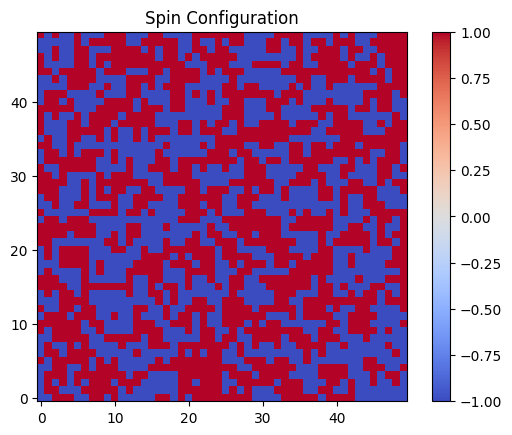

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define Lattice
class SquareLattice:
    def __init__(self, l):
        self.l = l
        self.N = l * l
        self.nnei = 4  # Number of neighbors in 2D square lattice
        self.neigh = self._compute_neighbors()

    def _compute_neighbors(self):
        neigh = np.zeros((self.N, self.nnei), dtype=int)
        for i in range(self.N):
            x, y = divmod(i, self.l)
            neigh[i, 0] = ((x + 1) % self.l) * self.l + y  # Right
            neigh[i, 1] = ((x - 1) % self.l) * self.l + y  # Left
            neigh[i, 2] = x * self.l + (y + 1) % self.l  # Up
            neigh[i, 3] = x * self.l + (y - 1) % self.l  # Down
        return neigh

# Initialize lattice
l = 50
lt = SquareLattice(l)
S = np.ones((l, l), dtype=int)

def dE(i, S, lt, J=1):
    x, y = divmod(i, lt.l)
    Eii = sum(S.flat[lt.neigh[i, j]] for j in range(lt.nnei))
    return -J * S[x, y] * Eii

def E(S, lt, J=1):
    return 0.5 * sum(dE(i, S, lt, J) for i in range(lt.N))

def M(S):
    return np.sum(S)

# Simulation parameters
beta = 0.2
J = 1
t = 10000
nskip = 10
nmeas = t // nskip

Ma = np.zeros(nmeas, dtype=int)
Ea = np.zeros(nmeas, dtype=int)

tm = 0
for ti in range(t):
    for _ in range(lt.N):
        ii = np.random.randint(lt.N)
        x, y = divmod(ii, lt.l)
        de = dE(ii, S, lt, J)
        if de > 0 or np.random.rand() < np.exp(2 * beta * de):
            S[x, y] *= -1

    if ti % nskip == 0:
        Ma[tm] = M(S)
        Ea[tm] = E(S, lt, J)
        tm += 1

# Compute averages
Mave, Mstd = np.mean(Ma / lt.N), np.std(Ma / lt.N)
Eave, Estd = np.mean(Ea / lt.N), np.std(Ea / lt.N)

# Plot results
plt.figure()
plt.imshow(S, cmap="coolwarm", origin="lower")
plt.colorbar()
plt.title("Spin Configuration")
plt.show()



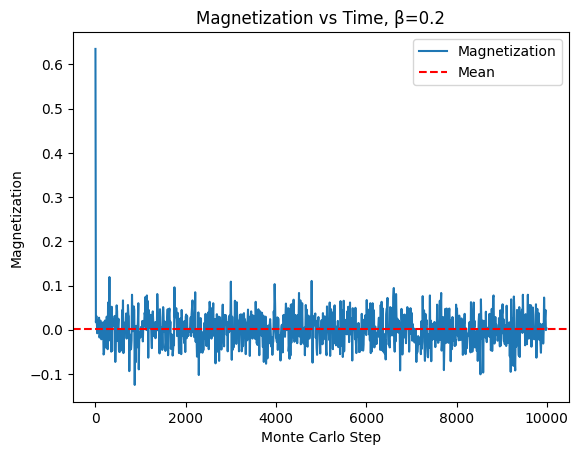

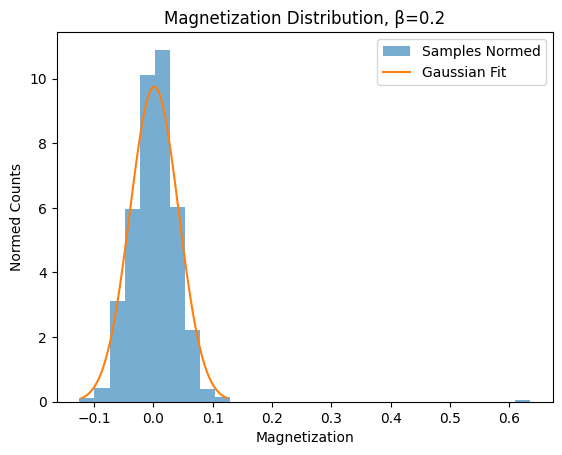

In [17]:
plt.figure()
plt.plot(range(0, t, nskip), Ma / lt.N, label="Magnetization")
plt.axhline(Mave, color="r", linestyle="dashed", label="Mean")
plt.xlabel("Monte Carlo Step")
plt.ylabel("Magnetization")
plt.title(f"Magnetization vs Time, β={beta}")
plt.legend()
plt.show()

plt.figure()
n, bins, _ = plt.hist(Ma / lt.N, density=True, bins=30, alpha=0.6, label="Samples Normed")
x = np.linspace(Mave - 3 * Mstd, Mave + 3 * Mstd, 100)
gaussian = (1 / (Mstd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - Mave) / Mstd) ** 2)
plt.plot(x, gaussian, label="Gaussian Fit")
plt.xlabel("Magnetization")
plt.ylabel("Normed Counts")
plt.title(f"Magnetization Distribution, β={beta}")
plt.legend()
plt.show()

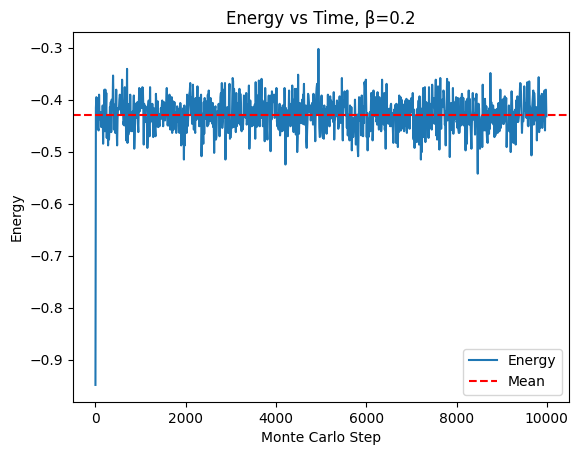

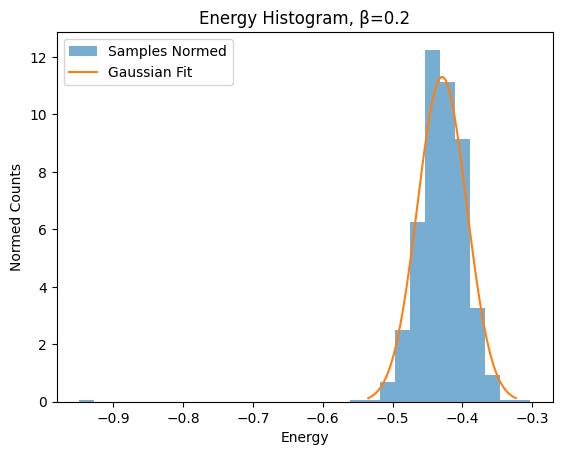

In [18]:
plt.figure()
plt.plot(range(0, t, nskip), Ea / lt.N, label="Energy")
plt.axhline(Eave, color="r", linestyle="dashed", label="Mean")
plt.xlabel("Monte Carlo Step")
plt.ylabel("Energy")
plt.title(f"Energy vs Time, β={beta}")
plt.legend()
plt.show()

plt.figure()
n, bins, _ = plt.hist(Ea / lt.N, density=True, bins=30, alpha=0.6, label="Samples Normed")
x = np.linspace(Eave - 3 * Estd, Eave + 3 * Estd, 100)
gaussian = (1 / (Estd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - Eave) / Estd) ** 2)
plt.plot(x, gaussian, label="Gaussian Fit")
plt.xlabel("Energy")
plt.ylabel("Normed Counts")
plt.title(f"Energy Histogram, β={beta}")
plt.legend()
plt.show()